# Chapter 3 Gaussian Elimination in Detail (Optional)

In [ ]:
# numerical and scientific computing libraries
import numpy as np
import scipy as sp

# plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# for pretty printing
np.set_printoptions(4, linewidth=100, suppress=True)

--------------------------------------------------------------------------------------------------------------

Let us have a more in-depth look on Gaussian elimination. We already know that performing Gaussian elimination on $A$ is nothing but multiplying an appropriate permutation matrice to the left and lower triangular elementary matrices. However, sometimes, we don't know which rows should be swapped in advance. Furthermore, in a so-called partial pivoting method to enhace numercial stablility, we choose an entry with biggest absolute value among pivot cadidates for each column. Thefore, for $j$-th column, we decide two rows to swap and a correponding permutation matrix $Q_j$ with a lower triangular matrix $L_j$ representing the elimination of entries below the pivot. So the Gaussian elimination under partial pivoting can be expressed by  
\begin{align*} L_k Q_{k-1} L_{k-1} \cdots Q_1 L_1 Q_0 A = U \end{align*}
for some upper triangular $U$. Notice that $Q_j$ can be an identity matrix, if we do not perform a row exchange in the $j$-th step. One observation here is the rows swapped in $Q_j$ are below $j$-th row and $L_j$ have non-zero off-diagonal entries lie in up to the $j$-th column. Therefore, the non-zero pattern of $Q_j L_j Q_j^{-1}$ coincides with that of $L_j$, which means we can re-write the decomposition as
\begin{align*} L_k L_{k-1}' \cdots L_1' Q_{k-1} \cdots Q_1 Q_0 A = LQA = U. \end{align*}
The triplet $(Q^\top, L^{-1}, U)$ is a usual output of numpy.linalg.lu function.

--------------------------------------------------------------------------------------------------------------

Suppose we are also given a vector $\mathbf{b}$, and we want to solve the equation $A \mathbf{x} = \mathbf{b}$.

Notice that 
\begin{align*}
A \mathbf{x} = \mathbf{b} &\Longleftrightarrow L_k P_k \dots L_1 P_1 A \mathbf{x} = L_k P_k \dots L_1 P_1 \mathbf{b} \\
&\Longleftrightarrow U\mathbf{x} = L_k P_k \dots L_1 P_1 \mathbf{b}.
\end{align*}

&nbsp;

Now, let us construct a block matrix $\begin{bmatrix} A & \mathbf{b} \end{bmatrix}$.
Then, by performing the same Gaussian elimination steps, which is mathematically equivalent to multiplying $L_k P_k \dots L_1 P_1$ on the left, we will get 
\begin{align*}
\begin{bmatrix} U  & L_k P_k \dots L_1 P_1 \mathbf{b}\end{bmatrix}.
\end{align*}
In other words, performing Gaussian elimination on the *augmented* matrix $\begin{bmatrix} A & \mathbf{b} \end{bmatrix}$ directly gives us a new equation whose set of solutions is equal to that of $A \mathbf{x} = \mathbf{b}$, but with an upper triangular matrix as the coefficient. We can then just "read off" the solution using back substitution.

In [2]:
n = m = 10
rng = np.random.RandomState(0)

A = rng.randint(10, size=(n, m))
b = rng.randint(10, size=n)

print("A =")
print(A)
print("b =")
print(b)


A =
[[5 0 3 3 7 9 3 5 2 4]
 [7 6 8 8 1 6 7 7 8 1]
 [5 9 8 9 4 3 0 3 5 0]
 [2 3 8 1 3 3 3 7 0 1]
 [9 9 0 4 7 3 2 7 2 0]
 [0 4 5 5 6 8 4 1 4 9]
 [8 1 1 7 9 9 3 6 7 2]
 [0 3 5 9 4 4 6 4 4 3]
 [4 4 8 4 3 7 5 5 0 1]
 [5 9 3 0 5 0 1 2 4 2]]
b =
[0 3 2 0 7 5 9 0 2 7]


In [3]:
col_b = b.reshape((-1, 1))
C = np.block([A, col_b])

C = C.astype(np.float64)  # integers to reals
print(C)

[[5. 0. 3. 3. 7. 9. 3. 5. 2. 4. 0.]
 [7. 6. 8. 8. 1. 6. 7. 7. 8. 1. 3.]
 [5. 9. 8. 9. 4. 3. 0. 3. 5. 0. 2.]
 [2. 3. 8. 1. 3. 3. 3. 7. 0. 1. 0.]
 [9. 9. 0. 4. 7. 3. 2. 7. 2. 0. 7.]
 [0. 4. 5. 5. 6. 8. 4. 1. 4. 9. 5.]
 [8. 1. 1. 7. 9. 9. 3. 6. 7. 2. 9.]
 [0. 3. 5. 9. 4. 4. 6. 4. 4. 3. 0.]
 [4. 4. 8. 4. 3. 7. 5. 5. 0. 1. 2.]
 [5. 9. 3. 0. 5. 0. 1. 2. 4. 2. 7.]]


In [4]:
def elimination(A, eps, verbose):
    A = A.copy()
    n, m = A.shape
    P_list = []
    L_list = []

    row_to_check = 0

    for j in range(m):
        # We test column by column to see if we can find a pivot.
        if row_to_check >= n :
            # Elimination is done on all n rows, even though there are
            # some columns not yet investigated. Anyway, task completed.
            break

        pivot = row_to_check
        for i in range(row_to_check+1, n):
            # We are exchanging rows "aggressively", so that the pivot
            # is always the largest possible among viable options.
            # This is because we will soon perform division by the pivot,
            # and dividing by a small number is susceptible to errors:
            # compare how different 1/0.0101 and 1/0.01 are,
            # to how different 1/100.0001 and 1/100 are.
            if abs(A[i, j]) > abs(A[pivot, j]) :
                pivot = i

        A[[row_to_check, pivot], :] = A[[pivot, row_to_check], :]

        r = row_to_check  # for notational clarity
        P = np.eye(n)
        P[r, r] = 0.
        P[pivot, pivot] = 0.
        P[r, pivot] = 1.
        P[pivot, r] = 1.
        P_list.append(P.copy())

        L = np.eye(n)

        if abs(A[r, j]) < eps :
            # All candidates for the pivots are essentially zero.
            # We cannot perform elimination with this column, so we skip.
            pass
        else :
            for k in range(r+1, n):
                u = A[k, j] / A[r, j]
                A[k, j:] -= u * A[j, j:]
                L[k, j] = -u
            row_to_check += 1  # next time we should start from the row below.

        L_list.append(L.copy())

        if verbose :
            print("After step", j+1, ":")
            print(A)
            print()

    return A, P_list, L_list

In [5]:
U, P_list, L_list = elimination(C, eps=1e-12, verbose=True)

After step 1 :
[[ 9.      9.      0.      4.      7.      3.      2.      7.      2.      0.      7.    ]
 [ 0.     -1.      8.      4.8889 -4.4444  3.6667  5.4444  1.5556  6.4444  1.     -2.4444]
 [ 0.      4.      8.      6.7778  0.1111  1.3333 -1.1111 -0.8889  3.8889  0.     -1.8889]
 [ 0.      1.      8.      0.1111  1.4444  2.3333  2.5556  5.4444 -0.4444  1.     -1.5556]
 [ 0.     -5.      3.      0.7778  3.1111  7.3333  1.8889  1.1111  0.8889  4.     -3.8889]
 [ 0.      4.      5.      5.      6.      8.      4.      1.      4.      9.      5.    ]
 [ 0.     -7.      1.      3.4444  2.7778  6.3333  1.2222 -0.2222  5.2222  2.      2.7778]
 [ 0.      3.      5.      9.      4.      4.      6.      4.      4.      3.      0.    ]
 [ 0.      0.      8.      2.2222 -0.1111  5.6667  4.1111  1.8889 -0.8889  1.     -1.1111]
 [ 0.      4.      3.     -2.2222  1.1111 -1.6667 -0.1111 -1.8889  2.8889  2.      3.1111]]

After step 2 :
[[ 9.      9.      0.      4.      7.      3.      2.     

In [6]:
# sanity check

U = A.copy()
for i in range(n-1) :
    U = L_list[i] @ P_list[i] @ U

print("U =")
print(U)

U =
[[ 9.      9.      0.      4.      7.      3.      2.      7.      2.      0.    ]
 [ 0.     -7.      1.      3.4444  2.7778  6.3333  1.2222 -0.2222  5.2222  2.    ]
 [-0.      0.      8.5714  8.746   1.6984  4.9524 -0.4127 -1.0159  6.873   1.1429]
 [ 0.     -0.      0.     -7.7056  0.2278 -1.4667  3.1222  6.3778 -6.2278  0.2   ]
 [ 0.      0.      0.      0.      6.5213  8.1557  5.4867  2.5955  1.4795  9.4333]
 [ 0.     -0.      0.      0.      0.      7.0469  9.6543  2.1111  3.8     8.9827]
 [ 0.     -0.      0.      0.      0.      0.      8.887   7.7447 -1.6208  0.5278]
 [-0.     -0.      0.      0.      0.      0.      0.     -5.0091  6.65    2.0411]
 [ 0.     -0.      0.     -0.     -0.      0.      0.     -0.     -5.6224 -3.3194]
 [-0.      0.      0.      0.      0.      0.     -0.      0.     -0.      1.2171]]


In [7]:
# sanity double check

_, _, U_aug = scipy.linalg.lu(C)
print(U_aug) 

[[ 9.      9.      0.      4.      7.      3.      2.      7.      2.      0.      7.    ]
 [ 0.     -7.      1.      3.4444  2.7778  6.3333  1.2222 -0.2222  5.2222  2.      2.7778]
 [ 0.      0.      8.5714  8.746   1.6984  4.9524 -0.4127 -1.0159  6.873   1.1429 -0.3016]
 [ 0.      0.      0.     -7.7056  0.2278 -1.4667  3.1222  6.3778 -6.2278  0.2    -0.8722]
 [ 0.      0.      0.      0.      6.5213  8.1557  5.4867  2.5955  1.4795  9.4333  6.6381]
 [ 0.      0.      0.      0.      0.      7.0469  9.6543  2.1111  3.8     8.9827  4.4667]
 [ 0.      0.      0.      0.      0.      0.      8.887   7.7447 -1.6208  0.5278 -1.809 ]
 [ 0.      0.      0.      0.      0.      0.      0.     -5.0091  6.65    2.0411  4.4331]
 [ 0.      0.      0.      0.      0.      0.      0.      0.     -5.6224 -3.3194 -2.0608]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.      1.2171 -6.3442]]


We already saw how to do back substitution, so let's skip that part.



---



You will sooner or later realize that computing $P$ and $L$ in the LU factorization $A = PLU$ is often not necessary.

For example, if we want to compute the rank, we can count the number of pivots from $U$.

In [8]:
# Spoiler alert: this is a rank 5 matrix.
A = np.array([[26., 40., 20., 30., 24., 31.,  9., 46., 34., 40.,],
              [25., 32., 20., 22., 27., 25.,  7., 31., 28., 29.,],
              [12., 18., 11., 10., 16., 10.,  8., 16., 21., 22.,],
              [ 7., 14., 11., 16.,  5.,  9.,  5., 17., 23., 17.,],
              [12., 23.,  8., 15., 12., 15.,  8., 28., 20., 28.,],
              [20., 30., 18., 24., 16., 25.,  5., 34., 27., 28.,],
              [12., 20., 10., 10.,  8., 17.,  3., 22., 13., 20.,],
              [22., 31., 16., 33., 30., 18., 13., 36., 39., 34.,]])

U, P_list, L_list = elimination(A, eps=1e-12, verbose=False)

In [9]:
rank = 0
eps = 1e-12
n, m = U.shape
prev_pivot = -1
for i in range(n):
    # search for pivot in the i-th row
    for j in range(prev_pivot+1, m):
        # We know that pivot is on right of the previous pivot.
        if abs(U[i, j]) > eps :
            # Pivot is found. We should move on to the next row,
            # but first things first...
            rank += 1  # increase rank count
            prev_pivot = j  # update last known pivot position
            break

print(rank)

5


However, computing the rank with a computer should be done with care.

This is because we will (almost) always have an issue with rounding errors when working with real numbers in computers.

In [10]:
1.1 - 1.0

0.10000000000000009

Reference: https://twitter.com/colin_fraser/status/1768580334159880492



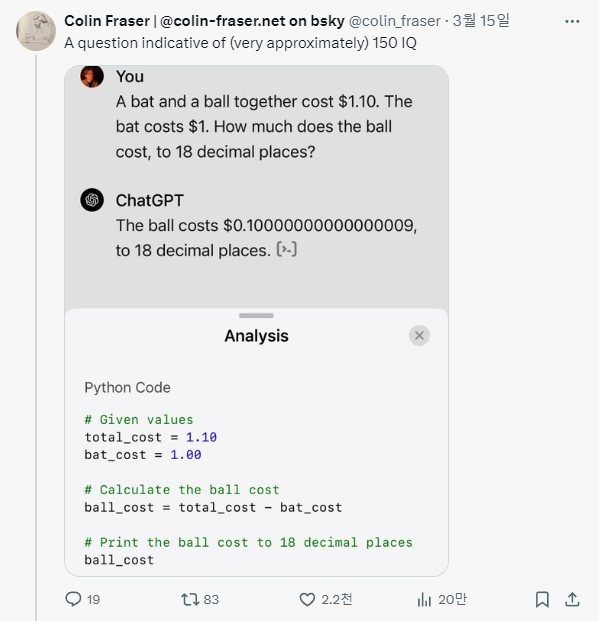

In [16]:
from IPython.display import Image
!wget -q -O /content/joke.jpg https://mathsci.kaist.ac.kr/~jsch/files/floating_joke.jpg

print("Reference: https://twitter.com/colin_fraser/status/1768580334159880492\n")
Image('/content/joke.jpg')

So, if the number we encounter is too small, it is in general impossible to tell whether it represents a truly nonzero quantity or the true value is zero but does not look like it because of rounding errors.

Also, because computers work with a fixed precision (in most cases about 16 significant figures for modern day computers), larger numbers invoke larger rounding errors.

Finding the right threshold is always a challenging task.

In [12]:
A = np.array([[ 1,  0,  0.1],
              [-1,  1,  0.2],
              [ 0, -1, -0.3]])

U, _, _ = elimination(A, eps=1e-12, verbose=False)

print(U[-1, -1]) # theoretically, this should be zero.

5.551115123125783e-17


In [13]:
A = np.array([[ 1,  np.exp(np.pi * np.sqrt(163))],
              [ 1,  262_537_412_640_768_247]])

U, _, _ = elimination(A, eps=1e-12, verbose=False)

print(U[-1, -1]) # theoretically, this should not be zero.

0.0
